# Decision Tree – Wine Quality (binaire)

Ce notebook applique un **arbre de décision** selon le cahier des charges :
- Classifier les vins
- Identifier les features les plus importantes
- Classification binaire : quality ≥6 → bon, <6 → moyen/mauvais
- Évaluation avec Accuracy, F1-score
- Suivi avec MLflow

## 1. Imports et configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
# Racine du projet (dossier contenant src/ et dataset/)
_roots = [os.getcwd(), os.path.join(os.getcwd(), '..'), os.path.join(os.getcwd(), '..', '..')]
for _r in _roots:
    _p = os.path.join(os.path.abspath(_r), 'src', 'preprocessing.py')
    if os.path.isfile(_p):
        ROOT = os.path.abspath(_r)
        sys.path.insert(0, os.path.join(ROOT, 'src'))
        break
else:
    raise FileNotFoundError("Dossier 'src' introuvable. Ouvrez le projet ML-project.")
from preprocessing import load_data, clean_data, scale_features, split_data
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("sqlite:///c:/Users/pc/Desktop/ML-project/classification/mlflow.db")
mlflow.set_experiment("wine-quality-decisiontree")

2026/02/14 17:38:18 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/14 17:38:18 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/14 17:38:18 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/14 17:38:18 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/14 17:38:18 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/14 17:38:18 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/14 17:38:19 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/14 17:38:19 INFO alembic.runtime.migration: Will assume non-transactional DDL.


<Experiment: artifact_location='file:///C:/Users/pc/Desktop/ML-project/classification/mlruns/1', creation_time=1770929394905, experiment_id='1', last_update_time=1770929394905, lifecycle_stage='active', name='wine-quality-decisiontree', tags={}>

## 2. Chargement et preprocessing

In [2]:
df = load_data(os.path.join(ROOT, "dataset", "winequality-red.csv"))
df = clean_data(df)

# Cible binaire
df["quality_binary"] = (df["quality"] >= 6).astype(int)

X = df.drop(columns=["quality", "quality_binary"])
y = df["quality_binary"]
feature_names = X.columns.tolist()

# Normalisation
X_scaled, scaler = scale_features(X)

# Train/test split
X_train, X_test, y_train, y_test = split_data(X_scaled, y, test_size=0.2, random_state=42)

print(f"Nombre de features: {len(feature_names)}")
print(f"Features: {feature_names}")

Nombre de features: 11
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


## 3. Entraînement du modèle

In [3]:
tree_clf = DecisionTreeClassifier(random_state=42, max_depth=5)
tree_clf.fit(X_train, y_train)

y_pred = tree_clf.predict(X_test)

# Métriques
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))

Accuracy: 0.669
F1-score: 0.683
Precision: 0.693
Recall: 0.674

Matrice de confusion:
[[85 43]
 [47 97]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       128
           1       0.69      0.67      0.68       144

    accuracy                           0.67       272
   macro avg       0.67      0.67      0.67       272
weighted avg       0.67      0.67      0.67       272



## 4. Feature importance (selon cahier des charges)

Feature importance:
                 feature  importance
10               alcohol    0.541619
9              sulphates    0.142733
6   total sulfur dioxide    0.084783
0          fixed acidity    0.046740
4              chlorides    0.033238
3         residual sugar    0.032675
1       volatile acidity    0.031985
5    free sulfur dioxide    0.031510
2            citric acid    0.021511
7                density    0.017405
8                     pH    0.015800


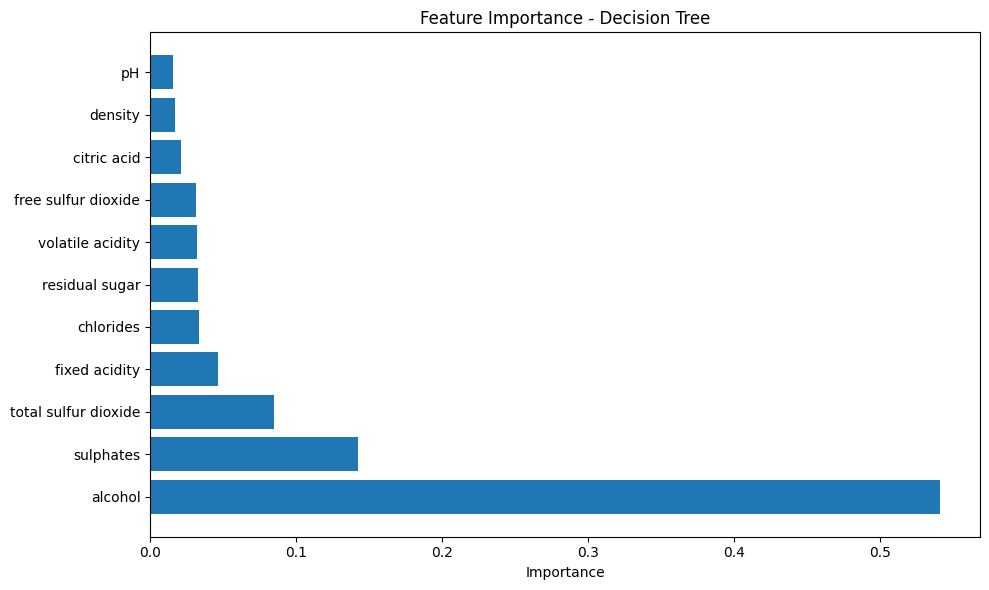

In [4]:
# Importance des features
feature_importance = tree_clf.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Feature importance:")
print(importance_df)

# Visualisation
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - Decision Tree')
plt.tight_layout()
plt.savefig("decisiontree_feature_importance.png")
plt.show()

## 5. Visualisation de l'arbre (simplifiée)

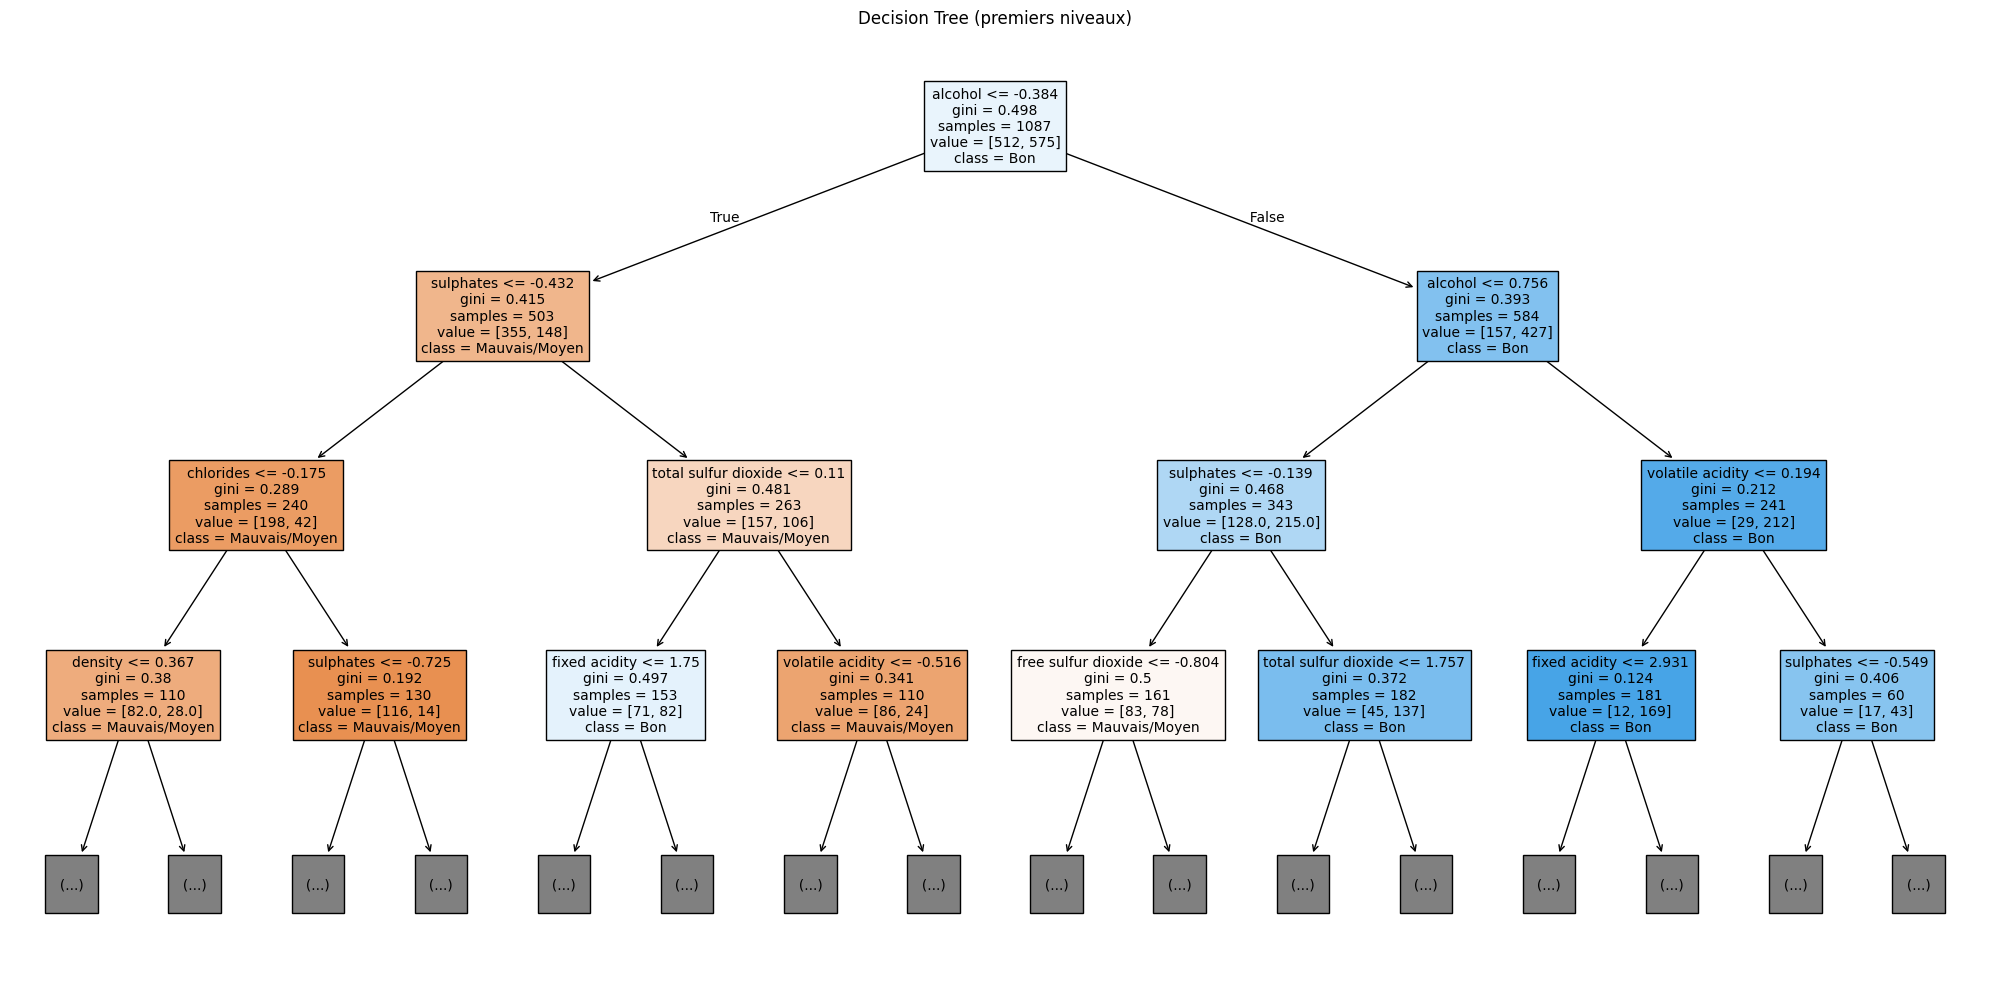

In [5]:
# Visualisation de l'arbre (premiers niveaux)
plt.figure(figsize=(20, 10))
plot_tree(tree_clf, feature_names=feature_names, class_names=['Mauvais/Moyen', 'Bon'], 
          filled=True, max_depth=3, fontsize=10)
plt.title('Decision Tree (premiers niveaux)')
plt.tight_layout()
plt.savefig("decisiontree_tree.png")
_cwd = os.getcwd()
_project_root = os.path.dirname(_cwd) if os.path.basename(_cwd) in ('classification','clustering','reduction') else _cwd
_fig_dir = os.path.join(_project_root, 'rapport', 'figures')
os.makedirs(_fig_dir, exist_ok=True)
plt.savefig(os.path.join(_fig_dir, 'decisiontree_tree.png'))
plt.show()

## 6. MLflow tracking

In [6]:
with mlflow.start_run(run_name="DecisionTree_binary"):
    mlflow.log_param("max_depth", 5)
    mlflow.log_param("random_state", 42)
    mlflow.log_metric("accuracy", float(acc))
    mlflow.log_metric("f1_score", float(f1))
    mlflow.log_metric("precision", float(precision))
    mlflow.log_metric("recall", float(recall))
    
    # Log feature importance
    for idx, row in importance_df.iterrows():
        mlflow.log_metric(f"feature_importance_{row['feature']}", float(row['importance']))
    
    mlflow.log_artifact("decisiontree_feature_importance.png")
    mlflow.log_artifact("decisiontree_tree.png")
    mlflow.sklearn.log_model(tree_clf, "decisiontree_model")
    print("MLflow run terminé")

2026/02/14 17:38:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


MLflow run terminé
